### Load labels (y)

In [1]:
import pandas as pd

labels = pd.read_csv("data/train_labels.csv")
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


id = image filename (without .tif)

label = y

0 → non-cancer

1 → cancer

### Basic EDA on y
How many cancer vs non-cancer images

Whether data is imbalanced

In [2]:
labels["label"].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

In [3]:
labels["label"].value_counts(normalize=True)

label
0    0.594969
1    0.405031
Name: proportion, dtype: float64

### Create a balanced subset of labels
Purpose:
Select a smaller, balanced sample of cancer and non-cancer cases to avoid class imbalance, 
reduce storage usage, and speed up training while preserving model quality.

#### Select balanced labels

In [5]:
# Number of samples per class
N_SAMPLES = 500

labels_0 = labels[labels["label"] == 0].sample(N_SAMPLES, random_state=42)
labels_1 = labels[labels["label"] == 1].sample(N_SAMPLES, random_state=42)

subset_labels = pd.concat([labels_0, labels_1]).reset_index(drop=True)

#### Verify balance
Purpose:
Ensure the dataset contains equal numbers of cancer and non-cancer images.

In [6]:
subset_labels["label"].value_counts()

label
0    500
1    500
Name: count, dtype: int64

#### Shuffle dataset

Purpose:
Remove ordering bias so models don’t see one class first.

In [7]:
subset_labels = subset_labels.sample(frac=1, random_state=42).reset_index(drop=True)
subset_labels.head()

,id,label
0,1a86ec7919ed270b0d63d803f6632a0b3645975a,1
1,1154d1696e1dbd7a26aa45a8e0de7ba11ca4ae59,1
2,84ce6b6dd97d305b9707ae130825819f8aeef03e,1
3,ee81981abfa01e660f8731c29c10767a6ab00cbd,1
4,1d6c4adba843f5ef08351065d06b175ef821f273,0


#### Save subset labels

Purpose:
Persist the sampled labels so experiments are reproducible.

In [8]:
subset_labels.to_csv("data/subset_labels.csv", index=False)

### Create image subset for EDA & modeling

Purpose:
Create a lightweight image dataset by copying only the selected samples. This avoids storage issues while enabling full EDA and model training.

##### Create subset image folder

Purpose:
Organize selected images in a dedicated directory.

##### Copy only selected images

Purpose:
Copy images corresponding to subset_labels.csv into the subset folder.

In [9]:
import zipfile
import os

ZIP_PATH = "data/histopathologic-cancer-detection.zip"
TARGET_DIR = "data/images_subset"

os.makedirs(TARGET_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, "r") as z:
    for image_id in subset_labels["id"]:
        image_path = f"train/{image_id}.tif"
        try:
            z.extract(image_path, TARGET_DIR)
        except KeyError:
            print(f"Missing: {image_id}")

##### Flatten folder structure

Purpose:
Move images from train/ into images_subset/ for easier loading.

In [10]:
import shutil

train_dir = os.path.join(TARGET_DIR, "train")

for fname in os.listdir(train_dir):
    shutil.move(
        os.path.join(train_dir, fname),
        os.path.join(TARGET_DIR, fname)
    )

os.rmdir(train_dir
)

##### Verify image count

Purpose:
Ensure all selected images were copied successfully.

In [11]:
len(os.listdir(TARGET_DIR))

1000

## Exploratory Data Analysis (Image Data)

### Load required libraries

Purpose:
Import libraries needed for image loading, visualization, and numerical analysis.

In [12]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [22]:
import os

PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

### Reload subset labels

Purpose:
Load the saved subset labels to link images with their target variable (y).

In [13]:
subset_labels = pd.read_csv("data/subset_labels.csv")
subset_labels.head()

,id,label
0,1a86ec7919ed270b0d63d803f6632a0b3645975a,1
1,1154d1696e1dbd7a26aa45a8e0de7ba11ca4ae59,1
2,84ce6b6dd97d305b9707ae130825819f8aeef03e,1
3,ee81981abfa01e660f8731c29c10767a6ab00cbd,1
4,1d6c4adba843f5ef08351065d06b175ef821f273,0


### Check image directory

Purpose:
Confirm that the subset image directory contains the expected number of images.

In [14]:
IMAGE_DIR = "data/images_subset"

len(os.listdir(IMAGE_DIR))

1000

### Inspect image dimensions

Purpose:
Understand image size and channels to guide preprocessing and model design.

Fixed image size

RGB images

Suitable for CNNs

In [15]:
sample_image_id = subset_labels.iloc[0]["id"]
sample_path = os.path.join(IMAGE_DIR, f"{sample_image_id}.tif")

img = cv2.imread(sample_path)
img.shape

(96, 96, 3)

### Display sample cancer vs non-cancer images

Purpose:
Visually compare cancer and non-cancer tissue samples.

In [16]:
def show_images(label, n=5):
    ids = subset_labels[subset_labels["label"] == label]["id"].sample(n, random_state=42)
    
    plt.figure(figsize=(12, 3))
    for i, image_id in enumerate(ids):
        img_path = os.path.join(IMAGE_DIR, f"{image_id}.tif")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
    
    title = "Cancer (label=1)" if label == 1 else "Non-Cancer (label=0)"
    plt.suptitle(title)
    plt.show()

In [26]:
def show_and_save_images(label, n=5):
    ids = subset_labels[subset_labels["label"] == label]["id"].sample(n, random_state=42)
    
    plt.figure(figsize=(12, 3))
    for i, image_id in enumerate(ids):
        img_path = os.path.join(IMAGE_DIR, f"{image_id}.tif")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
    
    title = "Cancer (label=1)" if label == 1 else "Non-Cancer (label=0)"
    plt.suptitle(title)
    
    # save
    filename = "cancer_samples.png" if label == 1 else "non_cancer_samples.png"
    plt.tight_layout()
    plt.savefig(os.path.join(PLOTS_DIR, filename), dpi=150)
    
    plt.show()


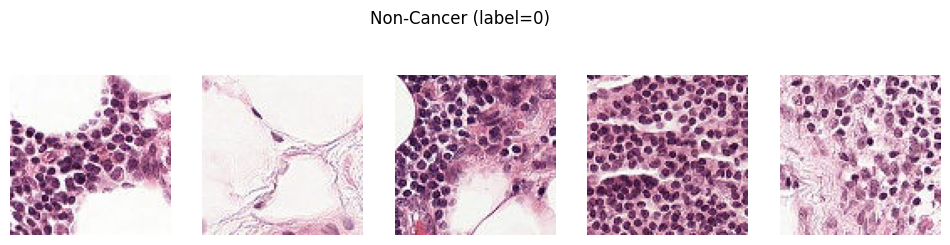

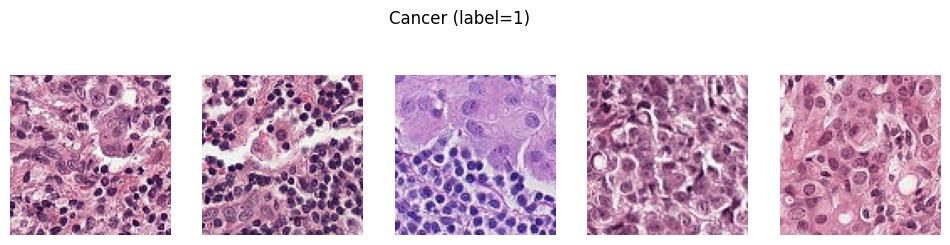

In [17]:
show_images(label=0)
show_images(label=1)

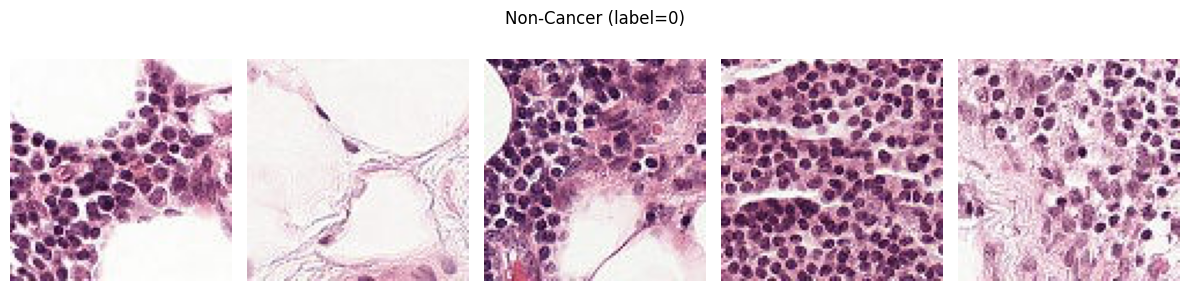

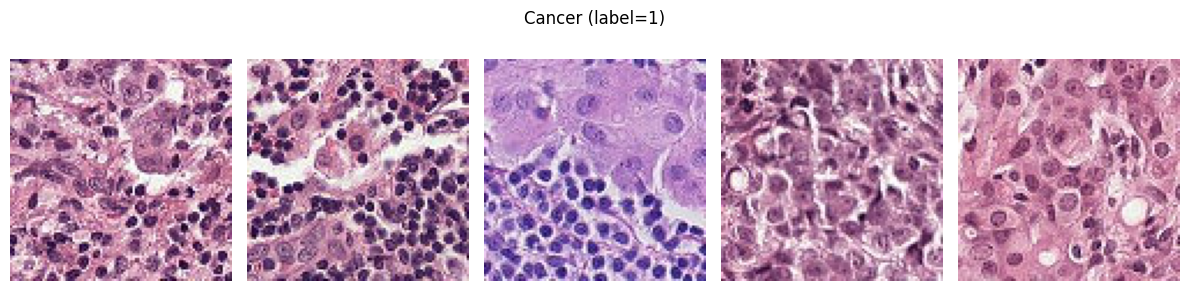

In [27]:
show_and_save_images(label=0)
show_and_save_images(label=1)

### Pixel intensity distribution

Purpose:
Analyze pixel value distribution to understand brightness and contrast.

Normalization

Scaling choices

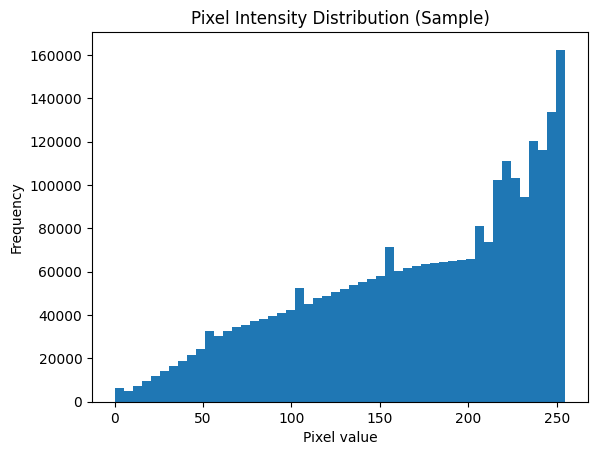

In [18]:
pixels = []

for image_id in subset_labels["id"][:100]:
    img_path = os.path.join(IMAGE_DIR, f"{image_id}.tif")
    img = cv2.imread(img_path)
    pixels.extend(img.flatten())

plt.hist(pixels, bins=50)
plt.title("Pixel Intensity Distribution (Sample)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

#### Class balance plot (y visualization)

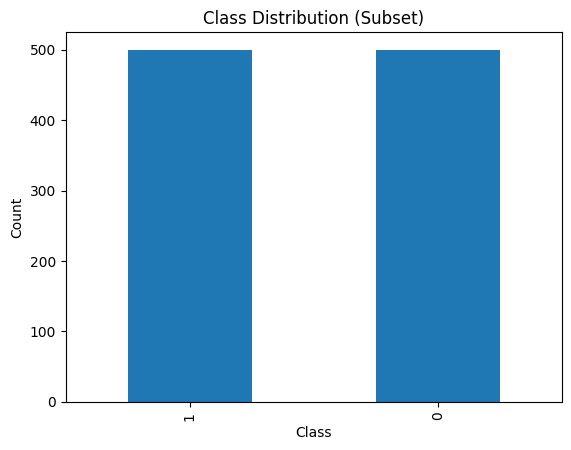

In [19]:
subset_labels["label"].value_counts().plot(
    kind="bar",
    title="Class Distribution (Subset)",
    xlabel="Class",
    ylabel="Count"
)
plt.show()

#### Mean image per class
Mean images highlight structural and color differences between cancerous and non-cancerous tissue.

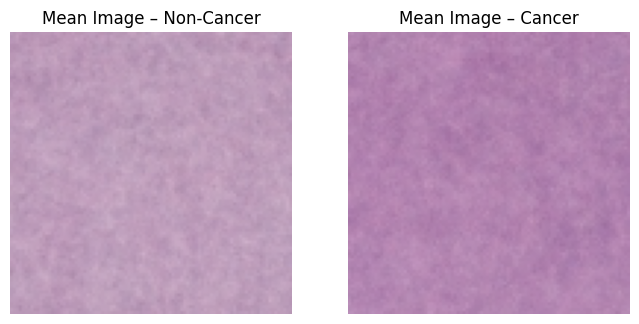

In [20]:
def mean_image(label):
    imgs = []
    ids = subset_labels[subset_labels["label"] == label]["id"][:100]
    
    for image_id in ids:
        img = cv2.imread(os.path.join(IMAGE_DIR, f"{image_id}.tif"))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
        
    return np.mean(imgs, axis=0).astype(np.uint8)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(mean_image(0))
plt.title("Mean Image – Non-Cancer")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mean_image(1))
plt.title("Mean Image – Cancer")
plt.axis("off")

plt.show()


#### Save class distribution plot

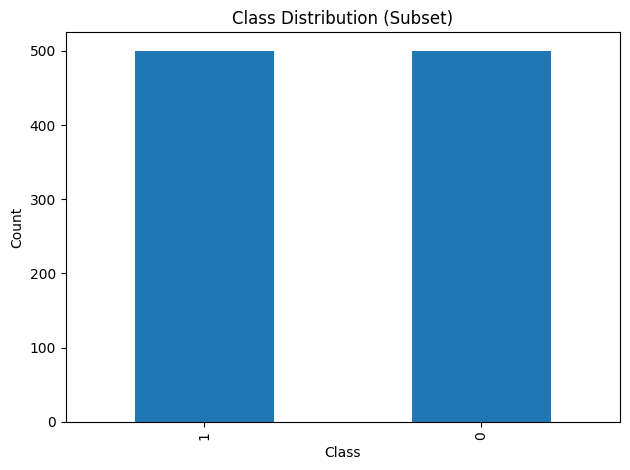

In [23]:
plt.figure()
subset_labels["label"].value_counts().plot(
    kind="bar",
    title="Class Distribution (Subset)",
    xlabel="Class",
    ylabel="Count"
)
plt.tight_layout()
plt.savefig("plots/class_distribution.png", dpi=150)
plt.show()

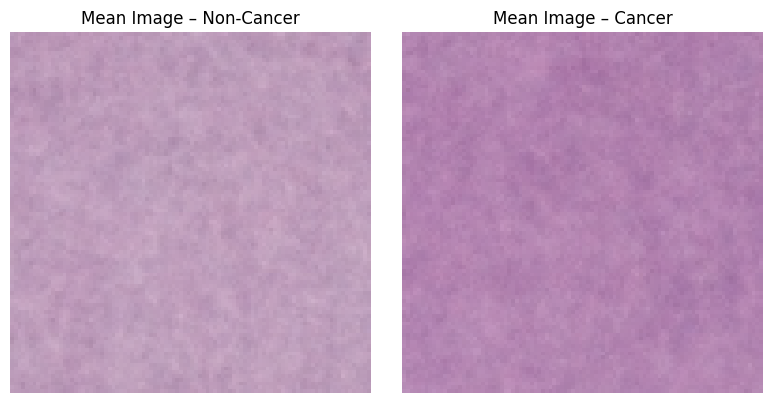

In [24]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(mean_image(0))
plt.title("Mean Image – Non-Cancer")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(mean_image(1))
plt.title("Mean Image – Cancer")
plt.axis("off")

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "mean_images.png"), dpi=150)
plt.show()

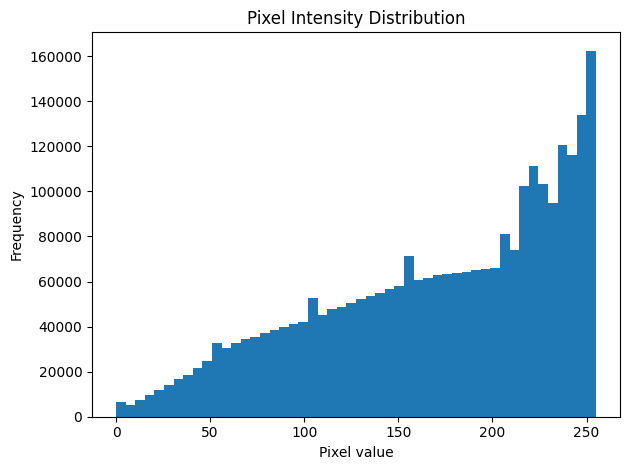

In [25]:
plt.figure()
plt.hist(pixels, bins=50)
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "pixel_intensity_hist.png"), dpi=150)
plt.show()

In [28]:
os.listdir("plots")

['cancer_samples.png',
 'pixel_intensity_hist.png',
 'class_distribution.png',
 'non_cancer_samples.png',
 'mean_images.png']

## EDA Summary:
The dataset consists of RGB histopathologic images with a fixed resolution of 96×96 pixels.

The class distribution was balanced by sampling equal numbers of cancer and non-cancer images.

Visual inspection shows noticeable texture and color differences between classes.

Pixel intensity analysis indicates values spanning the full 0–255 range, supporting normalization prior to modeling.